# f2e_inj (FACET-II electron injector) Reference simulation

In [1]:
%pylab --no-import-all inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
from impact import Impact
from distgen import Generator
import os

NAME = 'impact_f2e_inj_v0_300k_particles'

GFILE = os.path.expandvars('$FACET2_LATTICE/distgen/models/f2e_inj/v0/distgen.yaml')
YFILE = os.path.expandvars('$FACET2_LATTICE/impact/models/f2e_inj/v0/ImpactT.yaml')

In [3]:
assert os.path.exists(GFILE)
assert os.path.exists(YFILE)

In [4]:
%%time
G = Generator(GFILE)
G['n_particle'] = 300_000
G.run()
P0 = G.particles

CPU times: user 2 s, sys: 46.6 ms, total: 2.04 s
Wall time: 4.01 s


# MPI run 300k particles

For this many particles we will prepare an MPI run

In [5]:
I = Impact.from_yaml(YFILE)

# Set initial particles
I.initial_particles = P0

## Switches for MPI
I.numprocs = 128
#I.stop = 1.4
I.mpi_run

'mpirun -n {n} {command_mpi}'

In [6]:
# Change some things
I.header['Nx'] = 64
I.header['Ny'] = 64
I.header['Nz'] = 64

# Run on Cori (NERSC)

In [ ]:
%%time
I.command_mpi = '/global/homes/c/cmayes/cori/impact/bin/ImpactTv2.1_mpi'
I.workdir = os.path.expandvars('$SCRATCH')
I.mpi_run = 'salloc -N 2 -C haswell -q interactive -t 04:00:00 srun -n {n} {command_mpi} >log.txt' 
I.configure()

I.run()

# Run on SDF

This will run on SLAC's SDF. Note that you must have access to a partition (allocation) for instant response.

In [7]:
 # SDF setup    

PARTITION = 'ard' 
    
settings = { 
 'command': '/gpfs/slac/staas/fs1/g/g.beamphysics/cmayes/impact/ImpactTexe',    
 'command_mpi': '/gpfs/slac/staas/fs1/g/g.beamphysics/cmayes/impact/ImpactTexe-mpi',
 'mpi_run': 'salloc --partition '+f'{PARTITION}'+' -N 1 -n {n} /sdf/sw/gcc-4.8.5/openmpi-4.0.4/bin/mpirun -n {n} {command_mpi}'
   }
for k, v in settings.items():
    I[k] = v
    
I.workdir = os.path.expandvars('$SCRATCH')
I.configure()


In [8]:
%%time
I.run()

salloc: Pending job allocation 1300478
salloc: job 1300478 queued and waiting for resources
salloc: job 1300478 has been allocated resources
salloc: Granted job allocation 1300478
salloc: Waiting for resource configuration
salloc: Nodes ampt007 are ready for job
salloc: Relinquishing job allocation 1300478


CPU times: user 16.4 s, sys: 16.3 s, total: 32.7 s
Wall time: 7min 16s


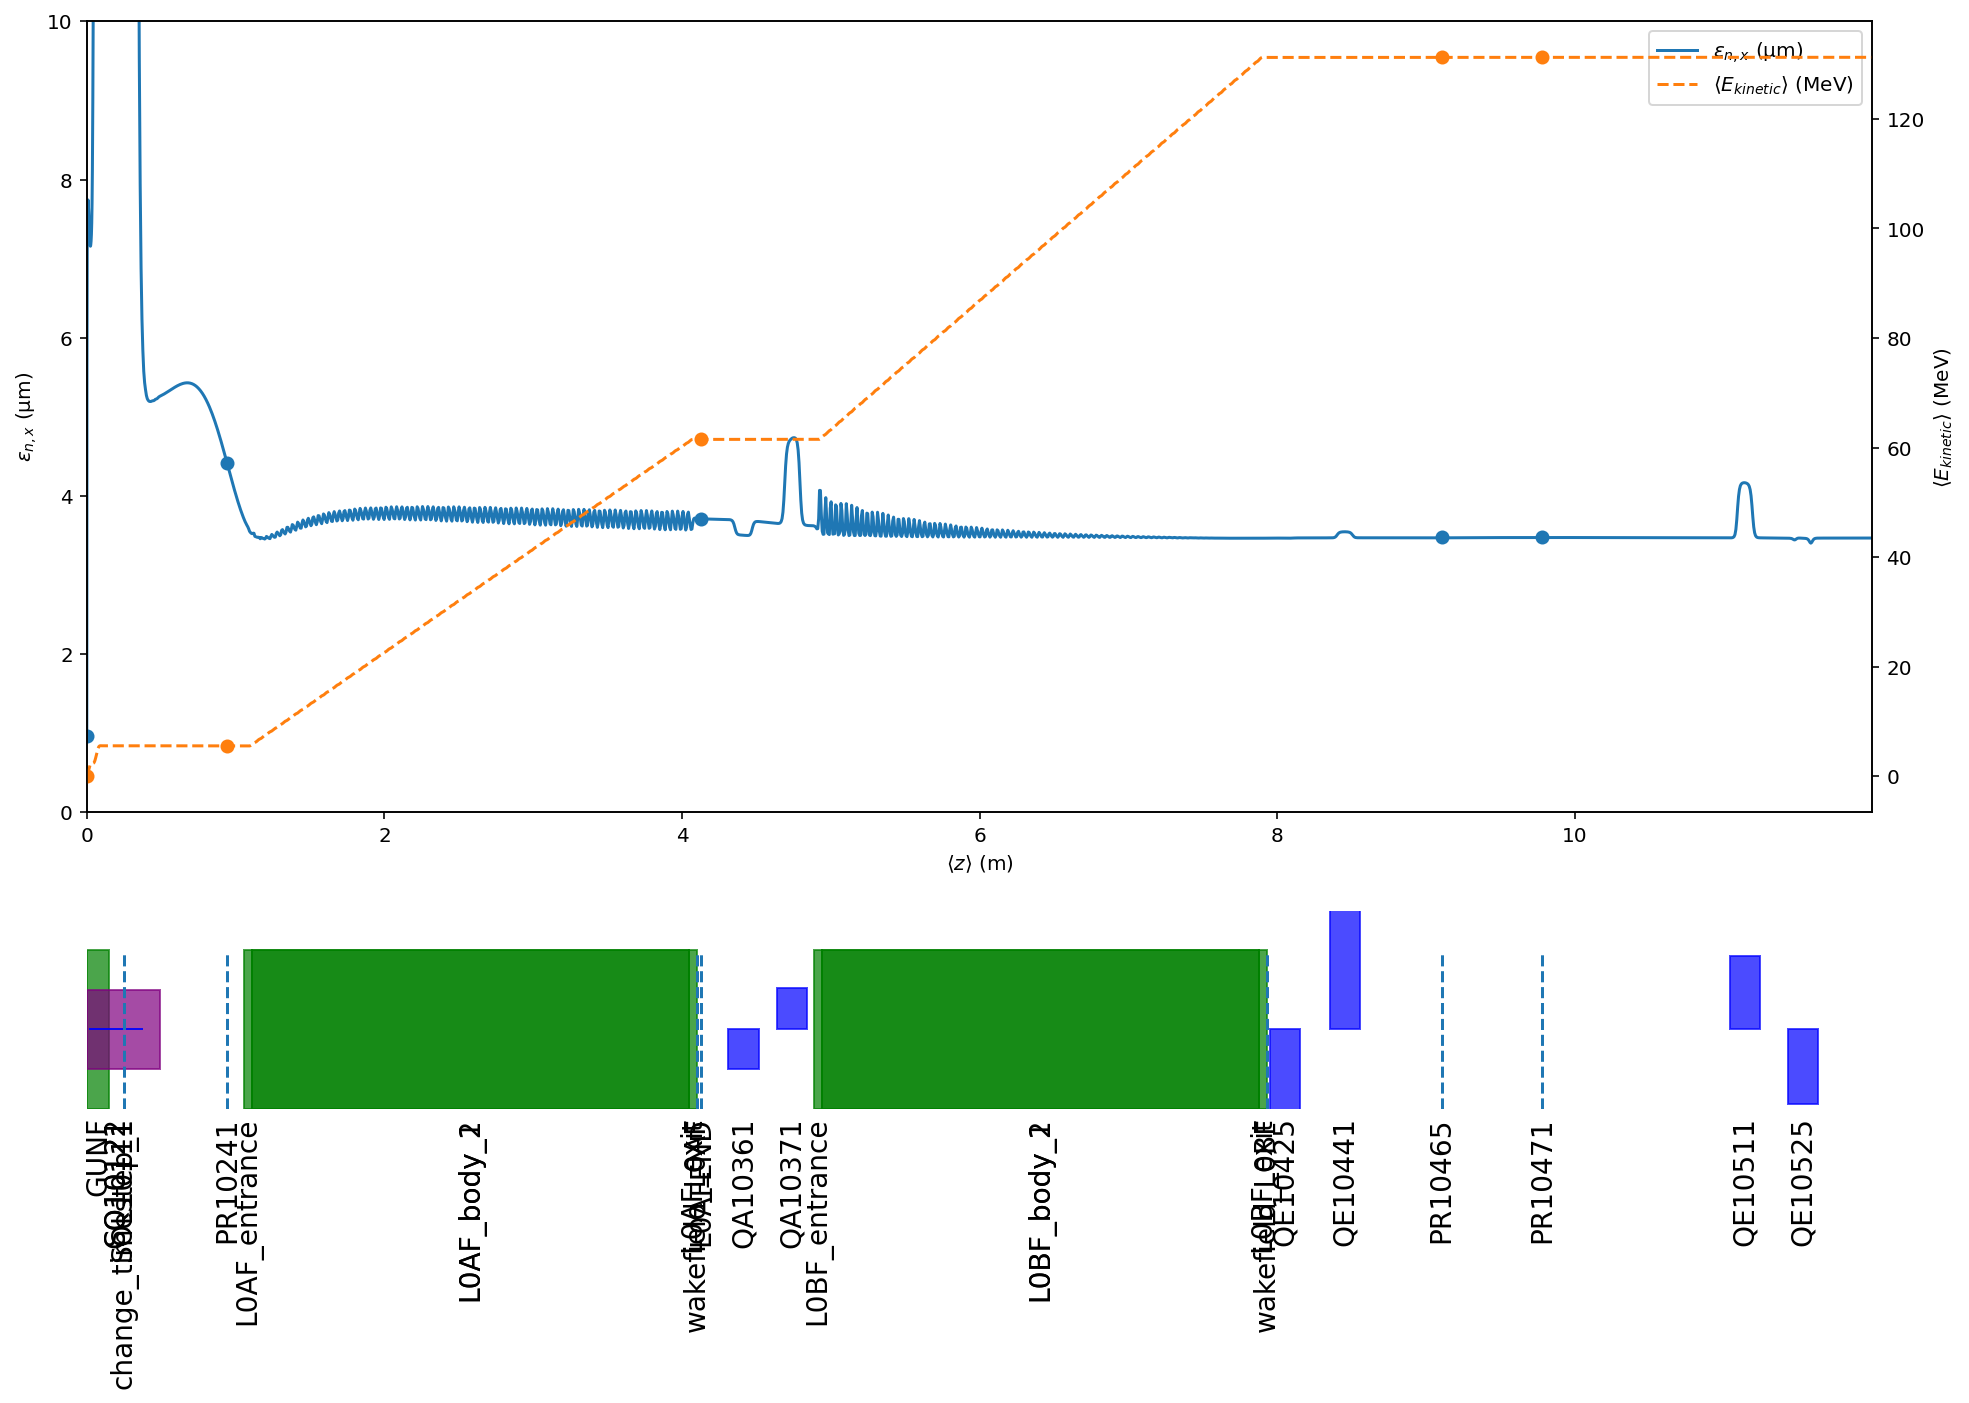

In [9]:
I.plot('norm_emit_x', y2='mean_kinetic_energy', ylim=(0, 10e-6), figsize=(16,10), include_labels=True)

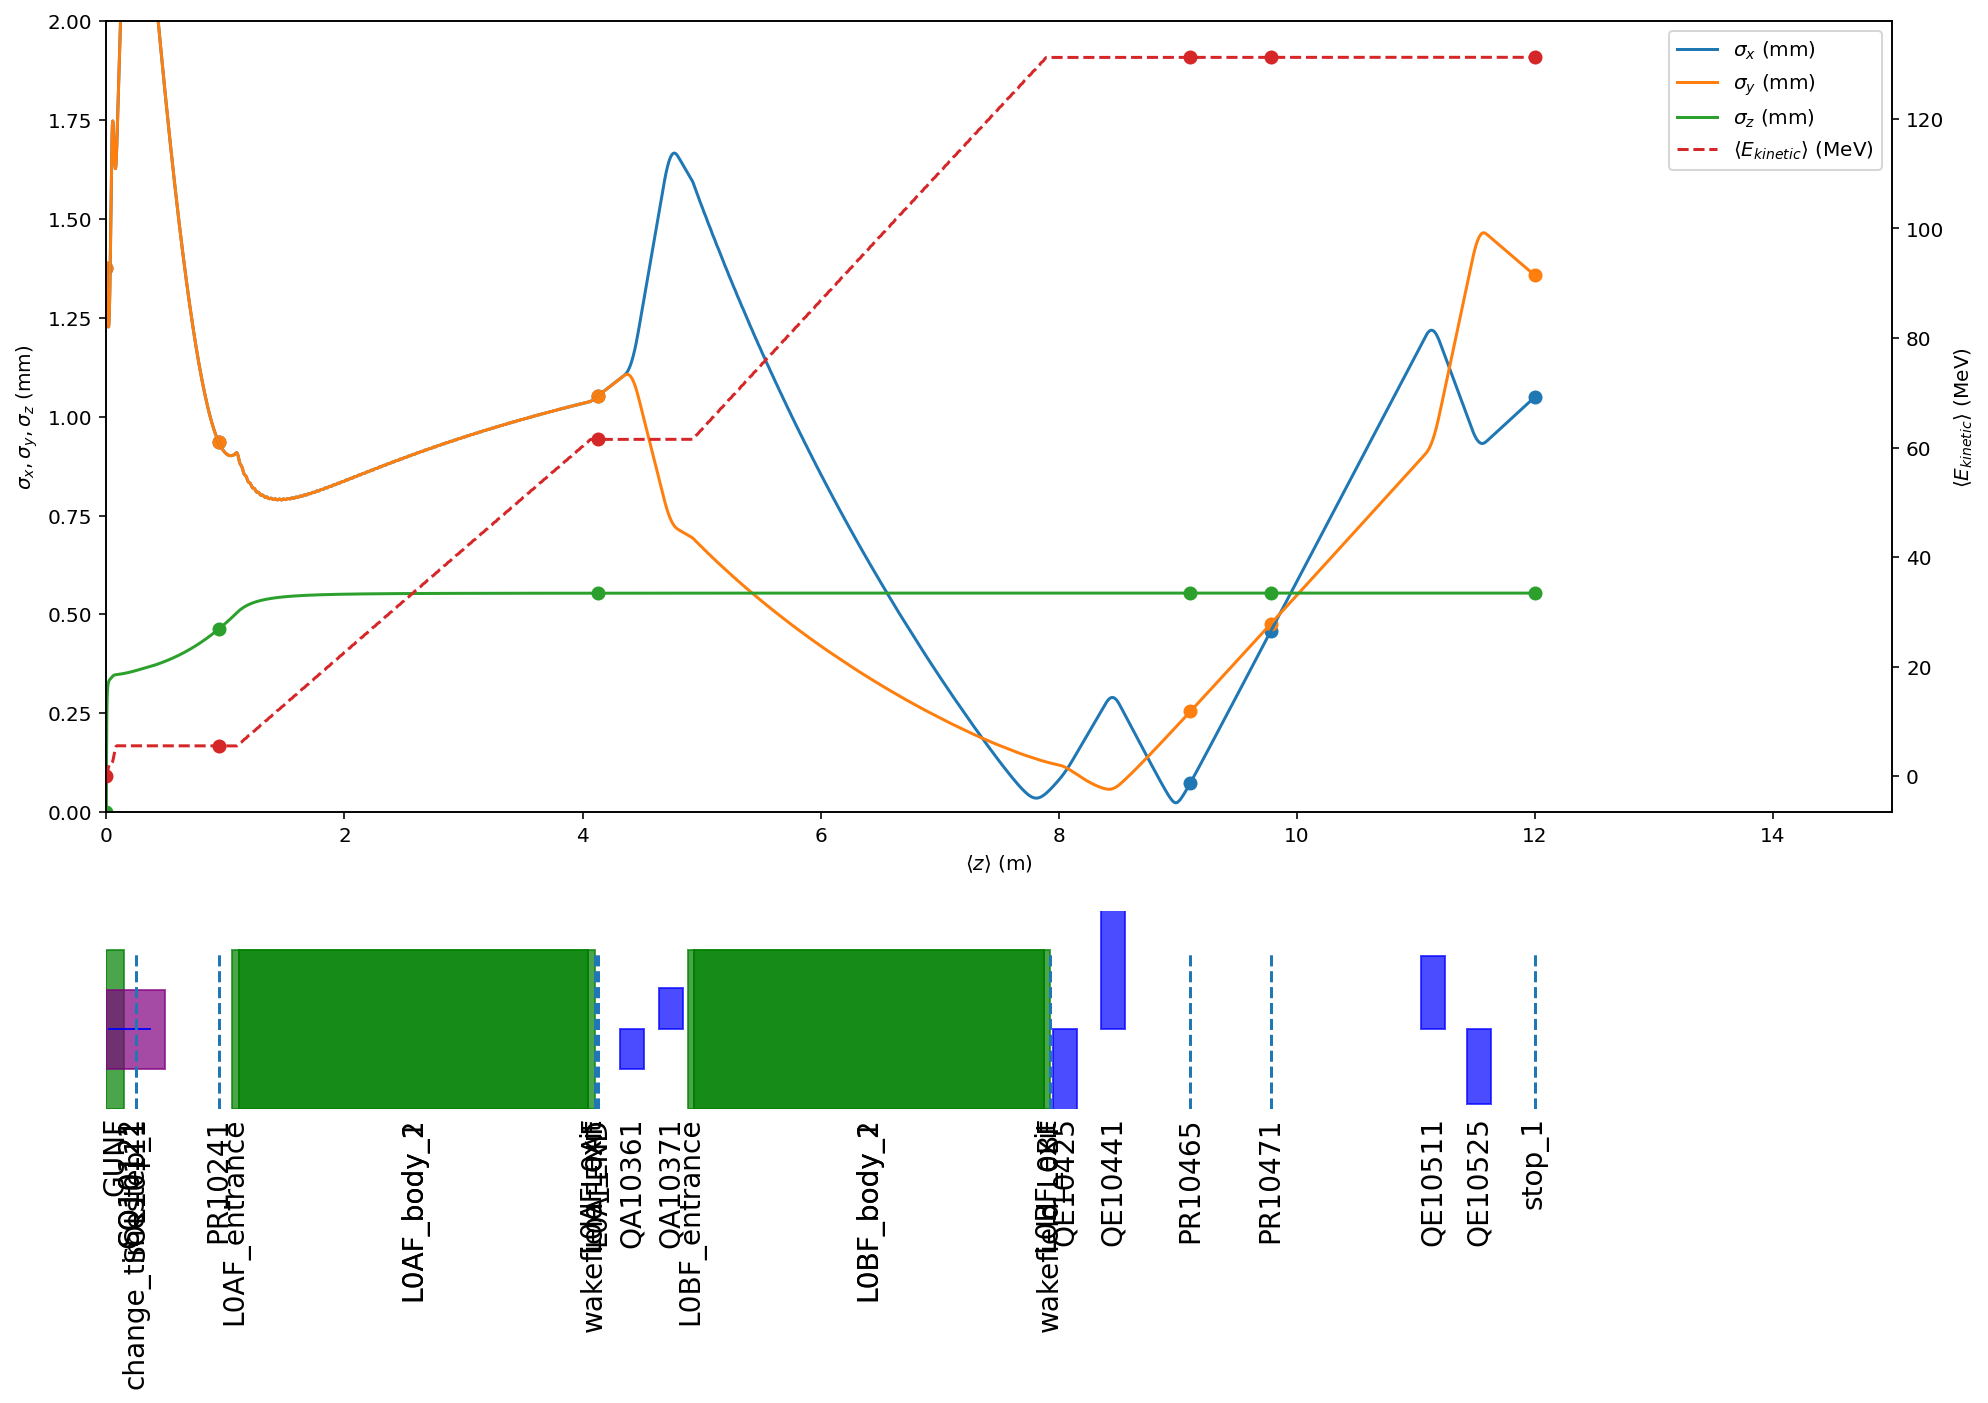

In [12]:
I.plot(['sigma_x', 'sigma_y', 'sigma_z'], y2='mean_kinetic_energy',  ylim=(0, 0.002), xlim=(0, 15), figsize=(16,10), include_labels=True)

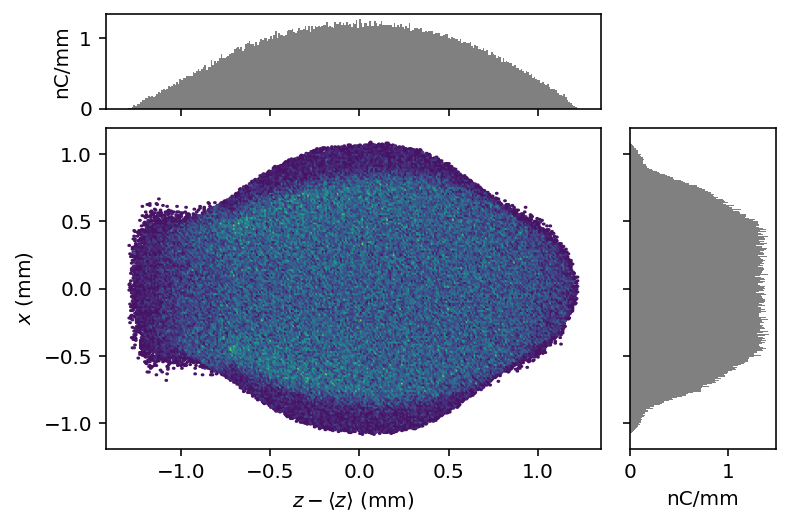

In [13]:
P1 = I.particles['PR10471']

P1.plot('delta_z', 'x')

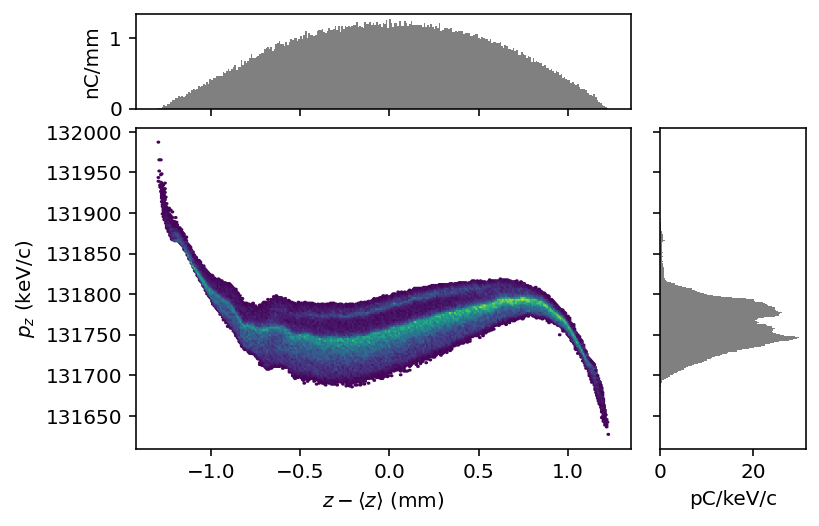

In [14]:
P1.plot('delta_z', 'pz')

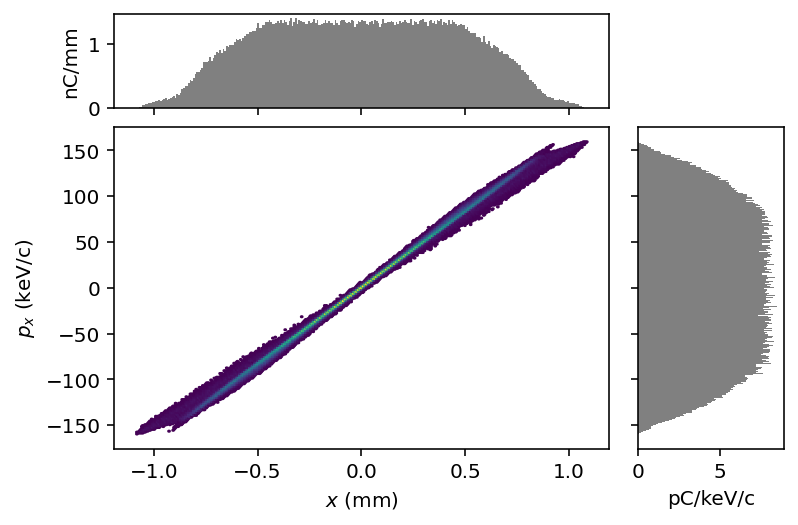

In [15]:
P1.plot('x', 'px')

In [16]:
# 95% Twiss and Emittance
P1.twiss('xy', 0.95)

{'alpha_x': -27.103939585840088,
 'beta_x': 21.326033687153043,
 'gamma_x': 34.4941563848328,
 'emit_x': 8.701185711112383e-09,
 'eta_x': -0.00032286720211263003,
 'etap_x': -0.000407380461622588,
 'norm_emit_x': 2.24357806214736e-06,
 'alpha_y': -14.643423489665118,
 'beta_y': 20.570850376039076,
 'gamma_y': 10.472578797647023,
 'emit_y': 9.16733830397676e-09,
 'eta_y': 0.00023619608070670048,
 'etap_y': 0.00027843131170776,
 'norm_emit_y': 2.363776004682549e-06}

In [ ]:
# Copy basic input to `v0/`
#!cp {I.path}/ImpactT.in {os.path.split(YFILE)[0]}
#!cp {I.path}/partcl.data {os.path.split(YFILE)[0]}

In [ ]:
# %%time
# afile = f'/global/cfs/cdirs/m669/www/lume/cu_inj/{NAME}.h5'
# I.archive(afile)

# WWW archive access

In [ ]:
# Restore
!wget https://portal.nersc.gov/cfs/m669/lume/f2e_inj/{NAME}.h5

In [ ]:
I2 = Impact.from_archive(f'{NAME}.h5')
I2.plot()